# Problem 2: Gaussian-Bernoulli Restricted Boltzmann Machines
## 2.2. GB-RBM on KMNIST

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

batch_size = 128
transform = transforms.Compose([transforms.ToTensor()])

train_set = torchvision.datasets.KMNIST(
    root='./data', train=True, download=True, transform=transform
)
test_set = torchvision.datasets.KMNIST(
    root='./data', train=False, download=True, transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=0
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, num_workers=0
)


100%|██████████| 18.2M/18.2M [00:21<00:00, 836kB/s] 
100%|██████████| 29.5k/29.5k [00:00<00:00, 168kB/s]
100%|██████████| 3.04M/3.04M [00:02<00:00, 1.16MB/s]
100%|██████████| 5.12k/5.12k [00:00<00:00, 1.75MB/s]


In [3]:
class RBM(nn.Module):
    """Gaussian–Bernoulli RBM (visible Gaussian, hidden Bernoulli)."""
    
    def __init__(self, D: int, F: int, k: int):
        super().__init__()
        self.W = nn.Parameter(torch.randn(F, D) * 1e-2)  # [F, D]
        self.c = nn.Parameter(torch.zeros(D))            # visible bias
        self.b = nn.Parameter(torch.zeros(F))            # hidden bias
        self.k = k                                       # CD-k steps
    
    def sample(self, p):
        """Sample Bernoulli with parameter p."""
        return torch.bernoulli(p)
    
    def sample_gaussian(self, mean):
        """Sample Gaussian N(mean, 1)."""
        return mean + torch.randn_like(mean)
        
    def P_h_x(self, x):
        """p(h=1 | x) for each hidden unit."""
        # x: [B, D] -> [B, F]
        logits = F.linear(x, self.W, self.b)
        return torch.sigmoid(logits)
    
    def P_x_h(self, h):
        """Mean of p(x | h) (Gaussian)."""
        # h: [B, F] -> [B, D]
        mean = F.linear(h, self.W.t(), self.c)
        return mean
        
    def free_energy(self, x):
        """Free energy F(x) for Gaussian–Bernoulli RBM with unit variance."""
        # v-term
        v_term = 0.5 * ((x - self.c) ** 2).sum(dim=1)
        # h-term: sum_j log(1 + exp(b_j + W_j v))
        wx_b = F.linear(x, self.W, self.b)
        h_term = F.softplus(wx_b).sum(dim=1)
        return v_term - h_term
        
    def forward(self, x):
        """
        Run CD-k starting from x.
        Returns:
          x_k        : final negative sample
          x_recon_mu : mean of p(x | h_k) (used for reconstruction plots)
        """
        x_k = x
        for _ in range(self.k):
            p_h_given_x = self.P_h_x(x_k)
            h_k = self.sample(p_h_given_x)
            x_mu = self.P_x_h(h_k)
            x_k = self.sample_gaussian(x_mu)
        # last mean (without noise) for nicer reconstructions
        x_recon_mu = self.P_x_h(self.P_h_x(x_k))
        return x_k, x_recon_mu


In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0.0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(data.size(0), -1).to(device)
        mean, std = data.mean(), data.std()
        data_norm = (data - mean) / std
        
        optimizer.zero_grad()
        
        # CD-k
        x_k, _ = model(data_norm)
        # contrastive divergence estimate of -log p(x)
        loss = (model.free_energy(data_norm) -
                model.free_energy(x_k.detach())).mean()
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        if (batch_idx + 1) % (len(train_loader) // 2) == 0:
            print('Train({})[{:.0f}%]: Loss: {:.4f}'.format(
                epoch, 100. * batch_idx / len(train_loader),
                train_loss / (batch_idx + 1)))


def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(data.size(0), -1).to(device)
            mean, std = data.mean(), data.std()
            data_norm = (data - mean) / std
            
            x_k, _ = model(data_norm)
            loss = (model.free_energy(data_norm) -
                    model.free_energy(x_k)).mean()
            test_loss += loss.item()
    
    test_loss = (test_loss * batch_size) / len(test_loader.dataset)
    print('Test({}): Loss: {:.4f}'.format(epoch, test_loss))

In [5]:
def show(img1, img2):
    npimg1 = img1.cpu().numpy()
    npimg2 = img2.cpu().numpy()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(np.transpose(npimg1, (1, 2, 0)), interpolation='nearest')
    axes[0].set_title("Original")
    axes[0].axis('off')
    axes[1].imshow(np.transpose(npimg2, (1, 2, 0)), interpolation='nearest')
    axes[1].set_title("Reconstruction")
    axes[1].axis('off')
    plt.show()

In [6]:
def reconstruction_mse(model, device, data_loader):
    model.eval()
    sq_err_sum = 0.0
    n_pixels = 0
    
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.view(data.size(0), -1).to(device)
            mean, std = data.mean(), data.std()
            data_norm = (data - mean) / std
            
            _, x_recon_norm = model(data_norm)
            x_recon = x_recon_norm * std + mean
            
            # MSE over all pixels
            mse_batch = F.mse_loss(x_recon, data, reduction='sum')
            sq_err_sum += mse_batch.item()
            n_pixels += data.numel()
    
    return sq_err_sum / n_pixels

M = 16
Train(1)[50%]: Loss: -45.4647
Train(1)[100%]: Loss: -63.3583
Test(1): Loss: -84.6611
Train(2)[50%]: Loss: -97.7533
Train(2)[100%]: Loss: -104.1220
Test(2): Loss: -107.0049
Train(3)[50%]: Loss: -119.5804
Train(3)[100%]: Loss: -122.7830
Test(3): Loss: -118.8012
Train(4)[50%]: Loss: -131.1427
Train(4)[100%]: Loss: -132.9202
Test(4): Loss: -126.7871
Train(5)[50%]: Loss: -138.4676
Train(5)[100%]: Loss: -139.6793
Test(5): Loss: -131.9055
Train(6)[50%]: Loss: -142.7850
Train(6)[100%]: Loss: -143.3994
Test(6): Loss: -133.7487
Train(7)[50%]: Loss: -144.9447
Train(7)[100%]: Loss: -145.4383
Test(7): Loss: -135.3678
Train(8)[50%]: Loss: -146.1320
Train(8)[100%]: Loss: -146.7899
Test(8): Loss: -136.2961
Train(9)[50%]: Loss: -147.7628
Train(9)[100%]: Loss: -148.1618
Test(9): Loss: -136.8142
Train(10)[50%]: Loss: -148.5743
Train(10)[100%]: Loss: -148.8958
Test(10): Loss: -138.1012
Train(11)[50%]: Loss: -149.4128
Train(11)[100%]: Loss: -149.6761
Test(11): Loss: -138.2358
Train(12)[50%]: Loss: -

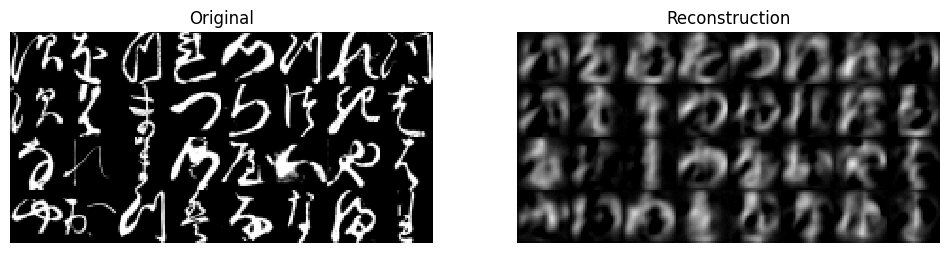

Sample reconstructions on train set for M=16


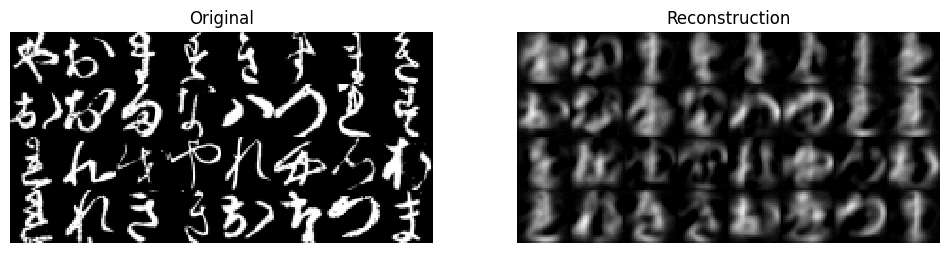

M=16: Train reconstruction MSE = 0.074537
M=16: Test  reconstruction MSE = 0.075677

M = 64
Train(1)[50%]: Loss: -84.7132
Train(1)[100%]: Loss: -112.9077
Test(1): Loss: -142.7905
Train(2)[50%]: Loss: -162.6840
Train(2)[100%]: Loss: -168.8877
Test(2): Loss: -167.4687
Train(3)[50%]: Loss: -183.8675
Train(3)[100%]: Loss: -187.4649
Test(3): Loss: -181.4940
Train(4)[50%]: Loss: -196.3436
Train(4)[100%]: Loss: -198.3927
Test(4): Loss: -190.5410
Train(5)[50%]: Loss: -204.8335
Train(5)[100%]: Loss: -205.9769
Test(5): Loss: -196.4883
Train(6)[50%]: Loss: -209.9194
Train(6)[100%]: Loss: -211.1158
Test(6): Loss: -201.4049
Train(7)[50%]: Loss: -214.0671
Train(7)[100%]: Loss: -214.7995
Test(7): Loss: -204.5763
Train(8)[50%]: Loss: -217.2933
Train(8)[100%]: Loss: -217.9169
Test(8): Loss: -207.2948
Train(9)[50%]: Loss: -219.6699
Train(9)[100%]: Loss: -220.1426
Test(9): Loss: -209.2623
Train(10)[50%]: Loss: -221.6876
Train(10)[100%]: Loss: -222.0221
Test(10): Loss: -211.3252
Train(11)[50%]: Loss: -222

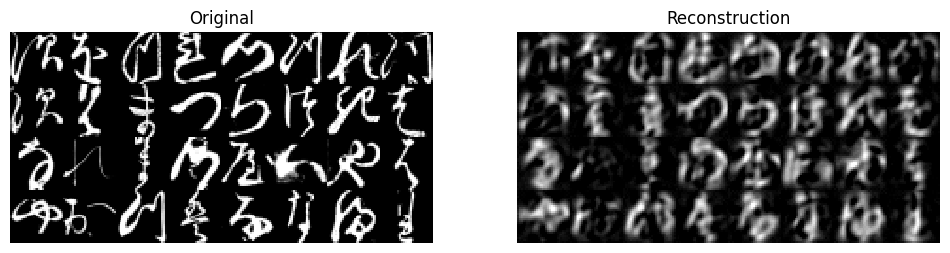

Sample reconstructions on train set for M=64


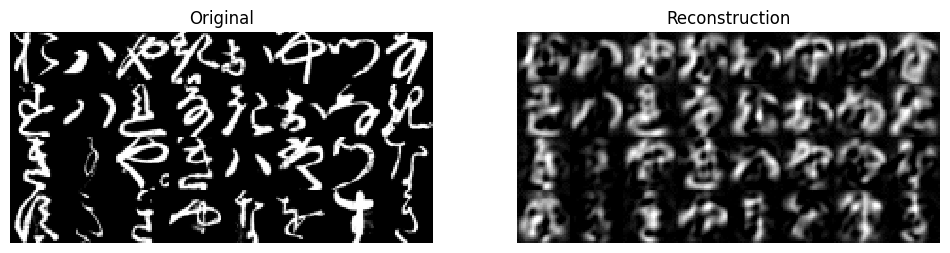

M=64: Train reconstruction MSE = 0.059141
M=64: Test  reconstruction MSE = 0.061102

M = 256
Train(1)[50%]: Loss: -130.2417
Train(1)[100%]: Loss: -167.0051
Test(1): Loss: -208.0395
Train(2)[50%]: Loss: -229.0704
Train(2)[100%]: Loss: -235.5944
Test(2): Loss: -235.5848
Train(3)[50%]: Loss: -250.8172
Train(3)[100%]: Loss: -253.1058
Test(3): Loss: -247.7673
Train(4)[50%]: Loss: -260.2081
Train(4)[100%]: Loss: -261.7731
Test(4): Loss: -253.8400
Train(5)[50%]: Loss: -266.1993
Train(5)[100%]: Loss: -267.3963
Test(5): Loss: -259.8221
Train(6)[50%]: Loss: -270.9623
Train(6)[100%]: Loss: -271.7264
Test(6): Loss: -263.5669
Train(7)[50%]: Loss: -274.4663
Train(7)[100%]: Loss: -275.3056
Test(7): Loss: -267.1778
Train(8)[50%]: Loss: -277.4988
Train(8)[100%]: Loss: -278.3500
Test(8): Loss: -270.3924
Train(9)[50%]: Loss: -280.3278
Train(9)[100%]: Loss: -281.1329
Test(9): Loss: -272.9337
Train(10)[50%]: Loss: -283.3339
Train(10)[100%]: Loss: -283.8218
Test(10): Loss: -276.1666
Train(11)[50%]: Loss: -2

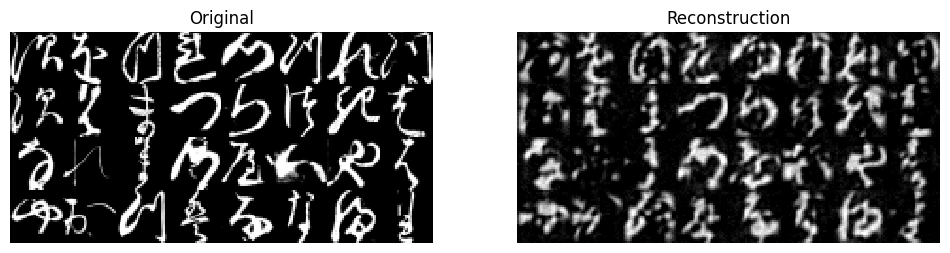

Sample reconstructions on train set for M=256


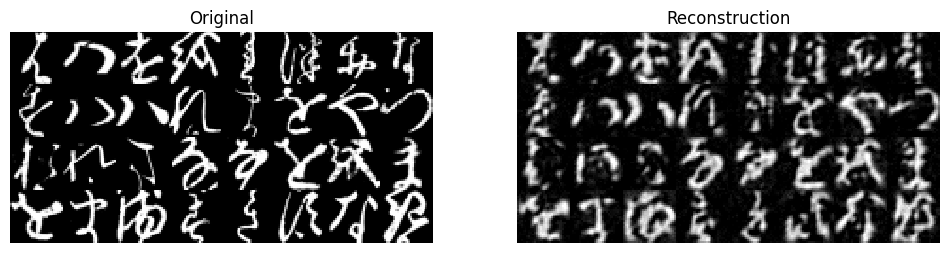

M=256: Train reconstruction MSE = 0.057000
M=256: Test  reconstruction MSE = 0.059685



In [ ]:
seed = 42
num_epochs = 25
torch.manual_seed(seed)

M_list = [16, 64, 256]
D = 28 * 28

for M in M_list:
    print("=" * 60)
    print(f"M = {M}")
    rbm = RBM(D=D, F=M, k=5).to(device)
    optimizer = optim.Adam(rbm.parameters(), lr=1e-3, weight_decay=0.0)
    
    for epoch in range(1, num_epochs + 1):
        train(rbm, device, train_loader, optimizer, epoch)
        test(rbm, device, test_loader, epoch)
    
    # --- reconstruction plots on train & test ---
    # test set
    data_test, _ = next(iter(test_loader))
    data_test = data_test[:32]
    data_size = data_test.size()
    data_flat = data_test.view(data_test.size(0), -1).to(device)
    mean, std = data_flat.mean(), data_flat.std()
    data_norm = (data_flat - mean) / std
    _, recon_norm = rbm(data_norm)
    recon = (recon_norm * std + mean).clamp(0, 1)
    
    print(f"Sample reconstructions on test set for M={M}")
    show(make_grid(data_flat.view(data_size), padding=0),
         make_grid(recon.view(data_size), padding=0))
    
    # train set
    data_train, _ = next(iter(train_loader))
    data_train = data_train[:32]
    data_size_tr = data_train.size()
    data_flat_tr = data_train.view(data_train.size(0), -1).to(device)
    mean_tr, std_tr = data_flat_tr.mean(), data_flat_tr.std()
    data_norm_tr = (data_flat_tr - mean_tr) / std_tr
    _, recon_norm_tr = rbm(data_norm_tr)
    recon_tr = (recon_norm_tr * std_tr + mean_tr).clamp(0, 1)
    
    print(f"Sample reconstructions on train set for M={M}")
    show(make_grid(data_flat_tr.view(data_size_tr), padding=0),
         make_grid(recon_tr.view(data_size_tr), padding=0))
    
    # --- report MSE on train & test ---
    train_mse = reconstruction_mse(rbm, device, train_loader)
    test_mse = reconstruction_mse(rbm, device, test_loader)
    print(f"M={M}: Train reconstruction MSE = {train_mse:.6f}")
    print(f"M={M}: Test  reconstruction MSE = {test_mse:.6f}\n")